In [56]:
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import math
from skimage import io
import pandas as pd
import random
import matplotlib.pyplot as plt
from skimage import measure
import cv2
import pytesseract
from paddleocr import PaddleOCR,draw_ocr
import Levenshtein
# Paddleocr supports Chinese, English, French, German, Korean and Japanese.
# You can set the parameter `lang` as `ch`, `en`, `fr`, `german`, `korean`, `japan`
# to switch the language model in order.
ocr = PaddleOCR(lang='en') # need to run only once to download and load model into memory

BASE_SIZE = (1024,1024)
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")
EPOCHS = 25
TESSERACT_PATH = r'D:\Tesseract\tesseract.exe'
pytesseract.pytesseract.tesseract_cmd=TESSERACT_PATH
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

from mrcnn.config import Config
from mrcnn import model as modellib, utils

import tensorflow.compat.v1 as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
OBJ_CLASSES = ["card", "name", "set_symbol"]
# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

from samples.mtg_card import fuzzy_search

[2023/01/21 16:44:45] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\kian/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\kian/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_score_thresh

In [57]:
def get_file_paths(dir_path):
    file_paths = []
    for root, directories, files in os.walk(dir_path):
        for file in files:
            if not file.startswith("."):
                file_path = os.path.join(root, file)
                file_path = os.path.abspath(file_path)
                file_paths.append(file_path)
    return file_paths

############################################################
#  Configurations
############################################################


class MTGCardTrainConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "mtg_card"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = len(OBJ_CLASSES) + 1  # Background + mtg_card classes

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 60

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.92

    USE_MINI_MASK = False
    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = BASE_SIZE[0]
    IMAGE_MAX_DIM = BASE_SIZE[1]

    BACKBONE = "resnet101"
    # Use smaller anchors because our image and objects are small
    # RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    # TRAIN_ROIS_PER_IMAGE = 32

    # use small validation steps since the epoch is small
    # VALIDATION_STEPS = 5


class MTGCardInferConfig(MTGCardTrainConfig):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.7


############################################################
#  Dataset
############################################################

class MTGCardDataset(utils.Dataset):

    def load_card(self, dataset_dir, subset):
        """Load a subset of the MTGCard dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes.
        for i, obj_class in enumerate(OBJ_CLASSES):
            self.add_class("mtg_card", i+1, obj_class)

        json_path = os.path.join(dataset_dir, "annotations.json")
        with open(json_path) as f:
            annotations = json.load(f)
        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        files = get_file_paths(dataset_dir)
        # Add images
        for image_path in files:
            fname = os.path.split(image_path)[-1]
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # I am using a constant shape for now
            height, width = BASE_SIZE
            # Keep only labels we want to classify
            polygons = {k:v for k,v in annotations[fname]['bbox'].items() if k in OBJ_CLASSES}

            self.add_image(
                "mtg_card",
                image_id=fname,  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "mtg_card":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


    def load_mask(self, image_id):
        """Load instance masks for the given image.

        Different datasets use different ways to store masks. This
        function converts the different mask format to one format
        in the form of a bitmap [height, width, instances].

        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a COCO image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "mtg_card":
            return super(self.__class__, self).load_mask(image_id)
        class_ids = []
        # Build mask of shape [height, width, instance_count] and list
        # of class IDs that correspond to each channel of the mask.
        mask = np.zeros([image_info["height"], image_info["width"], len(image_info["polygons"])],
                        dtype=np.uint8)
        for i, label in enumerate(image_info["polygons"]):
            class_id = OBJ_CLASSES.index(label)+1
            p = image_info["polygons"][label]
            x = [x[0] for x in p]
            y = [y[1] for y in p]
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(y, x)
            mask[rr, cc, i] = 1
            class_ids.append(class_id)
        

        return mask.astype(np.bool), np.array(class_ids, dtype=np.int32)

def train(model, dataset_dir, config):
    """Train the model."""
    # Training dataset.
    dataset_train = MTGCardDataset()
    dataset_train.load_card(dataset_dir, "train")
    dataset_train.prepare()
    # Validation dataset
    dataset_val = MTGCardDataset()
    dataset_val.load_card(dataset_dir, "val")
    dataset_val.prepare()
    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=EPOCHS,
                layers='heads')

def bitmask_to_bounding_box(bitmask):
    # Find the non-zero elements in the bitmask
    non_zero_elements = cv2.findNonZero(bitmask)

    # Use the minAreaRect function to find the bounding box of the rotated rectangle
    rect = cv2.minAreaRect(non_zero_elements)

    # Extract the bounding box points from the rect object
    bounding_box = cv2.boxPoints(rect)

    # Convert the bounding box points to integer values
    bounding_box = np.int0(bounding_box)

    return bounding_box

def resize_and_pad(image, target_shape):
    height, width = target_shape
    # Get the current height and width of the image
    rows, cols, channels = image.shape
    
    # Calculate the scaling factor for the height and width
    height_scale = height / rows
    width_scale = width / cols
    scale = min(height_scale, width_scale)
    
    # Calculate the new height and width of the image
    new_height = int(rows * scale)
    new_width = int(cols * scale)
    
    # Resize the image
    resized_image = cv2.resize(image, (new_width, new_height))
    
    # Calculate the padding needed
    top_pad = 0
    bottom_pad = 0
    left_pad = 0
    right_pad = 0
    if new_height < height:
        top_pad = (height - new_height) // 2
        bottom_pad = height - new_height - top_pad
    if new_width < width:
        left_pad = (width - new_width) // 2
        right_pad = width - new_width - left_pad
    
    # Pad the image
    padded_image = cv2.copyMakeBorder(resized_image, top_pad, bottom_pad, left_pad, right_pad, cv2.BORDER_CONSTANT, value=0)
    
    return padded_image


def reverse_resize_and_pad(padded_image, original_size):
    # Get the current height and width of the padded image
    height, width = padded_image.shape[:2]
    # Get the current height and width of the image
    rows, cols = original_size[:2]
    
    # Calculate the scaling factor for the height and width
    height_scale = height / rows
    width_scale = width / cols
    scale = min(height_scale, width_scale)
    
    # Calculate the new height and width of the image
    new_height = int(rows * scale)
    new_width = int(cols * scale)
    
    # Calculate the padding needed
    top_pad = 0
    bottom_pad = 0
    left_pad = 0
    right_pad = 0
    if new_height < height:
        top_pad = (height - new_height) // 2
        bottom_pad = height - new_height - top_pad
    if new_width < width:
        left_pad = (width - new_width) // 2
        right_pad = width - new_width - left_pad
    
    # Crop the image to remove the padding
    cropped_image = padded_image[top_pad:height-bottom_pad, left_pad:width-right_pad]
    # Resize the image
    resized_image = cv2.resize(cropped_image, (cols, rows))
    
    return resized_image


def draw_boxes(image, masks, class_ids, scores):
    # original image of shape (height, width, channels)
    # list of binary masks of shape (height, width)
    # list of class ids, one for each mask

    # Visualize the bounding boxes and class labels on top of the original image
    fig, ax = plt.subplots()

    # TODO: merge overlapping guesses first
    best_guess = {k:(-1*float('Inf'), None) for k in set(class_ids)}
    for i, class_id in enumerate(class_ids):
        top = best_guess[class_id]
        if top[0] < scores[i]:
            best_guess[class_id] = (scores[i], i)

    for class_id, (score, i) in best_guess.items():
        mask = masks[:, :, i]
        label = OBJ_CLASSES[class_id-1]
        # class_id = class_ids[i]
        coords = bitmask_to_bounding_box(mask.astype(np.uint8))
        if label == 'name':
            card_mask = masks[:, :, best_guess[OBJ_CLASSES.index('card')+1][1]]
            set_mask = masks[:, :, best_guess[OBJ_CLASSES.index('set_symbol')+1][1]]
            card_coords = bitmask_to_bounding_box(card_mask.astype(np.uint8))
            set_coords = bitmask_to_bounding_box(card_mask.astype(np.uint8))
            name_points = np.array(coords, dtype=np.int32)
            card_points = np.array(card_coords, dtype=np.int32)
            set_points = np.array(set_coords, dtype=np.int32)
            # Get the center-point of the card
            x, y, w, h = cv2.boundingRect(card_coords)
            center = (x + w // 2, y + h // 2)
            x, y, w, h = cv2.boundingRect(set_coords)
            center_set = (x + w // 2, y + h // 2)
            x, y, w, h = cv2.boundingRect(coords)
            center_name = (x + w // 2, y + h // 2)
            # Find top left corner as it's the closest to the farthest corner
            top_left = sorted(card_points, key=lambda point:np.linalg.norm(point - center_name))[0]
            top_left_name = sorted(name_points, key=lambda point:np.linalg.norm(point - top_left))[0]
            top_left_set = sorted(set_points, key=lambda point:np.linalg.norm(point - top_left_name))[0]

            if (top_left_name[0] < top_left_set[0] and top_left_name[1] < top_left_set[1]):
                angle = 0
            elif (top_left_name[0] >= top_left_set[0] and top_left_name[1] < top_left_set[1]):
                angle = -90
            elif (top_left_name[0] >= top_left_set[0] and top_left_name[1] >= top_left_set[1]):
                angle = 180
            elif (top_left_name[0] < top_left_set[0] and top_left_name[1] >= top_left_set[1]):
                angle = 90

            # Coarse rotation trim
            rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1)
            rotated_image = cv2.warpAffine(image.copy(), rotation_matrix, (image.shape[1], image.shape[0]))
            rotated_mask = cv2.warpAffine(mask.copy().astype(np.uint8), rotation_matrix, (mask.shape[1], mask.shape[0]))
            # Create a kernel for the dilation operation
            kernel = np.ones((int(mask.shape[1]*0.01), int(mask.shape[0]*0.025)), np.uint8)
            # Apply the dilation operation to the mask
            rotated_mask = cv2.dilate(rotated_mask, kernel, iterations=1)

            rotated_card_mask = cv2.warpAffine(masks[:, :, best_guess[OBJ_CLASSES.index('card')+1][1]].copy().astype(np.uint8), rotation_matrix, (mask.shape[1], mask.shape[0]))
            rotated_set_mask = cv2.warpAffine(masks[:, :, best_guess[OBJ_CLASSES.index('set_symbol')+1][1]].copy().astype(np.uint8), rotation_matrix, (mask.shape[1], mask.shape[0]))
            card_coords = bitmask_to_bounding_box(rotated_card_mask.astype(np.uint8))
            set_coords = bitmask_to_bounding_box(rotated_set_mask.astype(np.uint8))
            coords = bitmask_to_bounding_box(rotated_mask.astype(np.uint8))
            name_points = np.array(coords, dtype=np.int32)
            card_points = np.array(card_coords, dtype=np.int32)
            set_points = np.array(set_coords, dtype=np.int32)
            # Get the center-point of the card
            x, y, w, h = cv2.boundingRect(card_coords)
            center = (x + w // 2, y + h // 2)
            x, y, w, h = cv2.boundingRect(set_coords)
            center_set = (x + w // 2, y + h // 2)
            x, y, w, h = cv2.boundingRect(coords)
            center_name = (x + w // 2, y + h // 2)
            # Find top left corner as it's the closest to the farthest corner
            top_left = sorted(card_points, key=lambda point:np.linalg.norm(point - center_name))[0]
            top_left_name = sorted(name_points, key=lambda point:np.linalg.norm(point - top_left))[0]
            bottom_left_name, top_right_name, bottom_right_name = sorted(name_points, key=lambda point:np.linalg.norm(point - top_left_name))[1:]
            top_left_set = sorted(set_points, key=lambda point:np.linalg.norm(point - top_left_name))[0]            

            third_point = [bottom_left_name[0], bottom_right_name[1]]
            opp = np.linalg.norm(third_point - bottom_left_name)
            adj = np.linalg.norm(third_point - bottom_right_name)
            # Get the angle of rotation
            angle = np.arctan2(opp, adj)
            angle = np.rad2deg(angle)
            print(angle, center)
            rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1)
            rotated_image = cv2.warpAffine(rotated_image.copy(), rotation_matrix, (rotated_image.shape[1], rotated_image.shape[0]))
            rotated_mask = cv2.warpAffine(rotated_mask.copy().astype(np.uint8), rotation_matrix, (rotated_mask.shape[1], rotated_mask.shape[0]))
            rotated_set_mask = cv2.warpAffine(rotated_set_mask.copy().astype(np.uint8), rotation_matrix, (rotated_set_mask.shape[1], rotated_set_mask.shape[0]))
            # Create a kernel for the dilation operation
            kernel = np.ones((int(rotated_mask.shape[1]*0.01), int(rotated_mask.shape[0]*0.025)), np.uint8)
            # Apply the dilation operation to the mask
            rotated_mask = cv2.dilate(rotated_mask, kernel, iterations=1)
            coords = bitmask_to_bounding_box(rotated_mask.astype(np.uint8))
            name_points = np.array(coords, dtype=np.int32)

            # Find the minimum and maximum x and y coordinates of the original points
            min_x, min_y = np.min(name_points, axis=0)
            max_x, max_y = np.max(name_points, axis=0)
            # Crop the image using the minimum and maximum x and y coordinates
            cropped_image = rotated_image.copy()[min_y:max_y, min_x:max_x]
            # Define the destination image size
            dst_size = (max_x - min_x, max_y - min_y)
            # Resize the cropped image to the destination size
            cropped_image = cv2.resize(cropped_image, dst_size)
            text = ocr.ocr(cropped_image, det=False, cls=False)
            print("CardName: ", text)
            ax.imshow(cropped_image)
            # Show the image
            plt.show()
            fig, ax = plt.subplots()
            set_idx = OBJ_CLASSES.index('set_symbol')+1
            if set_idx in best_guess.keys():
                set_symbol_mask = masks[:, :, best_guess[set_idx][1]]
                rotated_mask = rotated_set_mask
                name_points = np.array(bitmask_to_bounding_box(rotated_mask.astype(np.uint8)), dtype=np.int32)
                # Find the minimum and maximum x and y coordinates of the original points
                min_x, min_y = np.min(name_points, axis=0)
                max_x, max_y = np.max(name_points, axis=0)
                # Crop the image using the minimum and maximum x and y coordinates
                cropped_image = rotated_image.copy()[min_y:max_y, min_x:max_x]
                # Define the destination image size
                dst_size = (max_x - min_x, max_y - min_y)
                # Resize the cropped image to the destination size
                cropped_image = cv2.resize(cropped_image, dst_size)
                ax.imshow(cropped_image)
                # Show the image
                plt.show()
                fig, ax = plt.subplots()
                card_name = text[0][0][0].lower()
                real_set_img, set_img_url = get_best_match(cropped_image, card_name)
                print("SET_URL:", set_img_url)
                ax.imshow(real_set_img)
                # Show the image
                plt.show()
                fig, ax = plt.subplots()
    for class_id, (score, i) in best_guess.items():
        mask = masks[:, :, i]
        label = OBJ_CLASSES[class_id-1]
        coords = bitmask_to_bounding_box(mask.astype(np.uint8))
        cv2.polylines(image, [coords], True, (0, 0, 255), 2)
    for class_id, (score, i) in best_guess.items():
        mask = masks[:, :, i]
        # class_id = class_ids[i]
        label = OBJ_CLASSES[class_id-1]
        coords = bitmask_to_bounding_box(mask.astype(np.uint8))
        x, y, w, h = cv2.boundingRect(coords)
        center_x, center_y = x + w // 2, y + h // 2
        # Convert the coordinates to a numpy array
        coords = np.array(coords, dtype=np.int32)
        # Add black border
        cv2.putText(image, label, (center_x, center_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 3, cv2.LINE_AA)
        # Put the label text on the image
        cv2.putText(image, label, (center_x, center_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)
    # Display the image
    ax.imshow(image)
    # Show the image
    plt.show()

def detect_and_color_splash(model, image_path):
    # Run model detection and generate the color splash effect
    print("Running on {}".format(image_path))
    # Read image
    image = skimage.io.imread(image_path)
    # Detect objects
    r = model.detect([image], verbose=1)[0]
    try:
        draw_boxes(image, r['masks'], r['class_ids'], r['scores'])
    except:
        print("damn no boxes c':")


def detect_and_guess(model, image_path):
    # Run model detection and generate the color splash effect
    print("Running on {}".format(image_path))
    # Read image
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    orig_shape = image.shape[:2]
    resized_image = resize_and_pad(image, (1024,1024))
    # Detect objects
    r = model.detect([resized_image], verbose=1)[0]
    resized_masks = []
    for i in range(r['masks'].shape[2]):
        mask = r['masks'][:,:,i]
        nm = reverse_resize_and_pad(mask.astype(np.uint8), orig_shape)
        resized_masks.append(nm)
    r_masks = np.stack(resized_masks, axis=2)
    # draw_boxes(resized_image, r['masks'], r['class_ids'], r['scores'])
    draw_boxes(image, r_masks, r['class_ids'], r['scores'])



Initalize paths and configs

In [58]:
data_dir = r"D:\processed_pics"

logs_dir = os.path.join(os.path.join(ROOT_DIR, "assets", "augmented_data"), "logs")

test_train_file = '00d594df-c51b-4936-9af1-536dab1792ae_02a16hbe-550x550_jpeg_0.jpg'

config = MTGCardTrainConfig()


Use the Next block to train model, skip if you only want to run inference on the latest model

In [59]:

if not True:
    from keras.backend import manual_variable_initialization 
    manual_variable_initialization(False) 

    model = modellib.MaskRCNN(mode="training", config=config,
                                    model_dir=logs_dir)

    # weights_path = model.get_imagenet_weights() 
    weights_path = model.find_last()
    print(weights_path)

    tf.keras.Model.load_weights(model.keras_model, weights_path, by_name=True, skip_mismatch=['output_layer'])

    train(model, data_dir, config)

Use this block to test the model

In [60]:

config = MTGCardInferConfig()


inference_model = model = modellib.MaskRCNN(mode="inference", config=config,
                                model_dir=logs_dir)
weights_path = model.find_last()
print(weights_path)

tf.keras.Model.load_weights(model.keras_model, weights_path, by_name=True)
# model.load_weights(weights_path, by_name=True)

dataset_dir = os.path.join(data_dir, 'test')
files = get_file_paths(dataset_dir)



d:\aktwelve_mask_rcnn\assets\augmented_data\logs\mtg_card20230121T1326\mask_rcnn_mtg_card_0025.h5


In [61]:
def get_best_match(image, card_name):
    image_list = fuzzy_search.get_set_images_by_name(card_name.lower(), shape=image.shape)
    query_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Back to 3 channel because I am having trouble with 1 channel
    query_image = cv2.cvtColor(query_image, cv2.COLOR_GRAY2BGR)
    # Convert the images to uint8
    query_image = cv2.normalize(query_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    reference_images = [np.uint8(cv2.cvtColor((255 - x[0][:,:,-1]), cv2.COLOR_GRAY2BGR)) for x in image_list]
    reference_images = [cv2.normalize(x, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U) for x in reference_images]
    # Compute the distances
    print(query_image.shape, type(query_image), query_image.dtype)
    print(reference_images[0].shape, type(reference_images[0]), reference_images[0].dtype)
    # Create an ORB object
    orb = cv2.ORB_create()

    # Compute the keypoints and descriptors for the query image
    query_kp, query_des = orb.detectAndCompute(query_image, None)

    # Initialize the minimum distance and index
    min_distance = float('inf')
    min_index = -1

    # Loop over the reference images
    for i, reference_image in enumerate(reference_images):
        # Compute the keypoints and descriptors for the reference image
        reference_kp, reference_des = orb.detectAndCompute(reference_image, None)

        # Use the Brute-Force matcher to find the closest keypoints
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        try:
            matches = bf.match(query_des, reference_des)
        except Exception as e:
            print('FUCK')
            fig, ax = plt.subplots()
            ax.imshow(query_image)
            # Show the image
            plt.show()
            fig, ax = plt.subplots()
            ax.imshow(reference_image)
            # Show the image
            plt.show()
            print(e)
            print(query_des, reference_des)
            return image_list[0]

        # Compute the total distance
        distance = sum([m.distance for m in matches])

        # Update the minimum distance and index if necessary
        if distance < min_distance:
            min_distance = distance
            min_index = i

    # Return the reference image with the minimum distance
    return image_list[min_index]

Running on D:\processed_pics\test\2357e43a-Photo_on_1-20-23_at_12.02_AM_3_1024x1024.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
1.562224916842398 (549, 425)
CardName:  [[('Masma Jet', 0.9520642757415771)]]


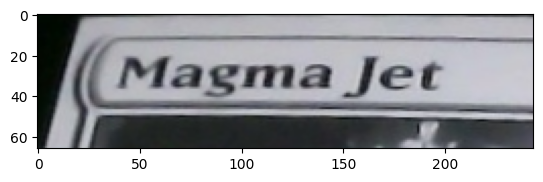

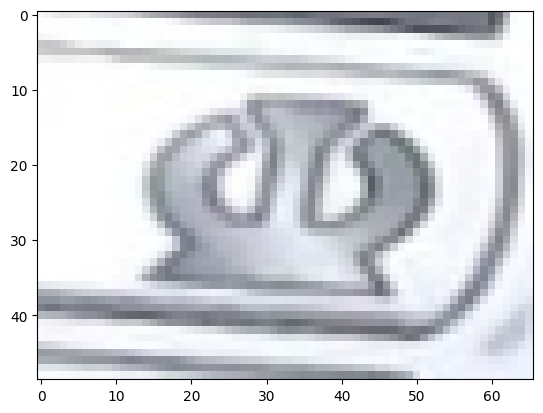

guessing with ratio of 0.09523809523809523: magma jet
https://svgs.scryfall.io/sets/5dn.svg?1673845200
https://svgs.scryfall.io/sets/td0.svg?1673845200
https://svgs.scryfall.io/sets/ddl.svg?1673845200
https://svgs.scryfall.io/sets/dd2.svg?1673845200
https://svgs.scryfall.io/sets/dci.svg?1673845200
https://svgs.scryfall.io/sets/ths.svg?1673845200
https://svgs.scryfall.io/sets/mtgo.svg?1673845200
https://svgs.scryfall.io/sets/mm3.svg?1673845200
https://svgs.scryfall.io/sets/jmp.svg?1673845200
(49, 66, 3) <class 'numpy.ndarray'> uint8
(49, 66, 3) <class 'numpy.ndarray'> uint8
SET_URL: https://svgs.scryfall.io/sets/5dn.svg?1673845200


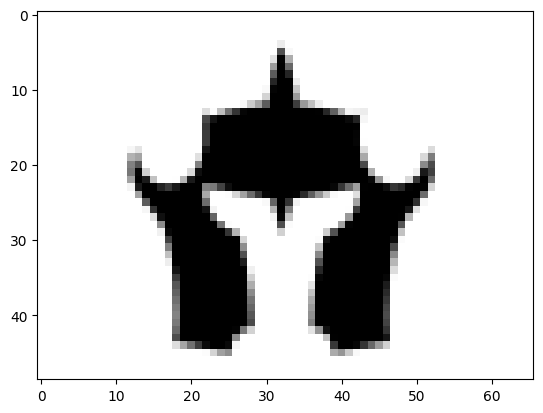

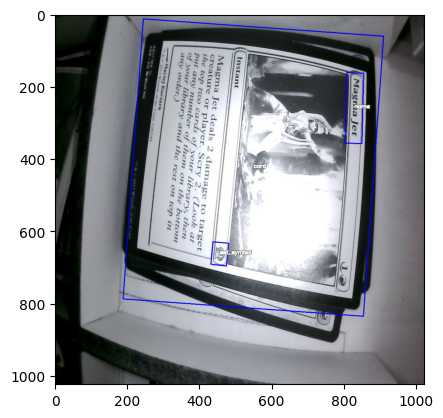

Running on D:\processed_pics\test\344b0840-Photo_on_1-19-23_at_11.56_PM_1024x1024.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
2.4195092166563366 (646, 467)
CardName:  [[('Ebony Fly', 0.9397581815719604)]]


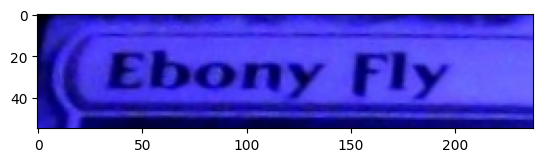

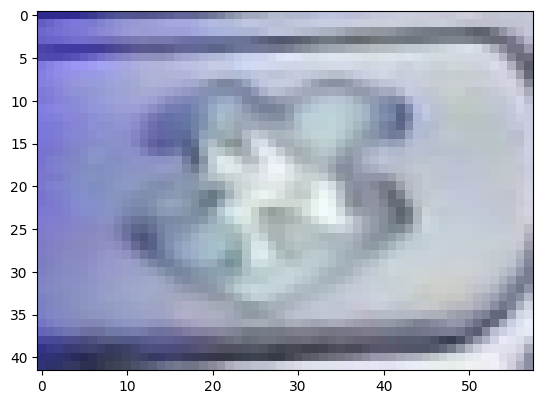

Found exact match: ebony fly
https://svgs.scryfall.io/sets/afc.svg?1673845200
(42, 58, 3) <class 'numpy.ndarray'> uint8
(42, 58, 3) <class 'numpy.ndarray'> uint8
SET_URL: https://svgs.scryfall.io/sets/afc.svg?1673845200


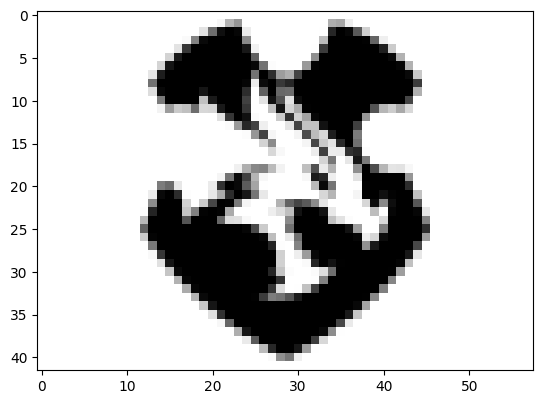

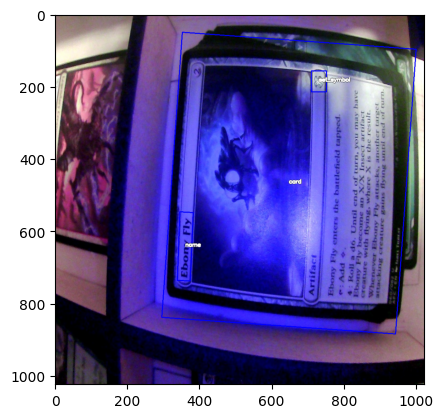

Running on D:\processed_pics\test\70d84fa0-Photo_on_1-20-23_at_12.02_AM_2_1024x1024.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
0.0 (549, 417)
CardName:  [[('Srory Seeker', 0.9819355607032776)]]


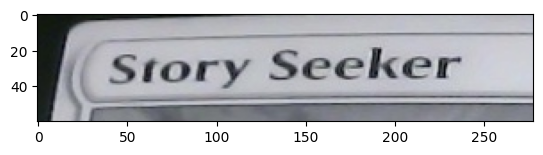

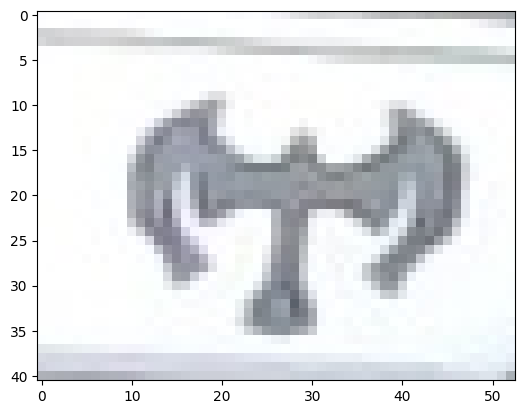

guessing with ratio of 0.16666666666666663: story seeker
https://svgs.scryfall.io/sets/khm.svg?1673845200
(41, 53, 3) <class 'numpy.ndarray'> uint8
(41, 53, 3) <class 'numpy.ndarray'> uint8
SET_URL: https://svgs.scryfall.io/sets/khm.svg?1673845200


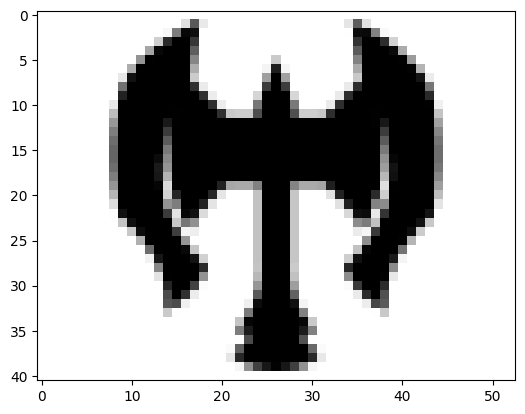

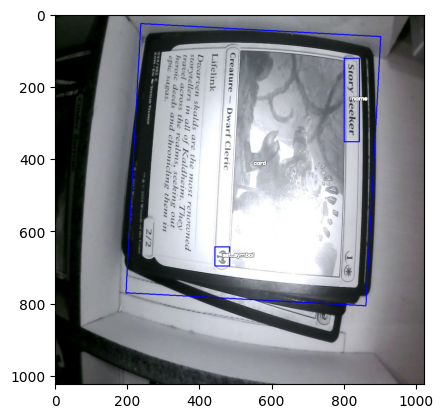

Running on D:\processed_pics\test\79f9a088-Photo_on_1-19-23_at_11.50_PM_1024x1024.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
2.0675418046210887 (469, 479)
CardName:  [[('Abattoir Ghoul', 0.9526624083518982)]]


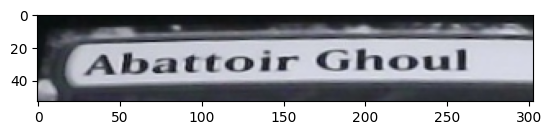

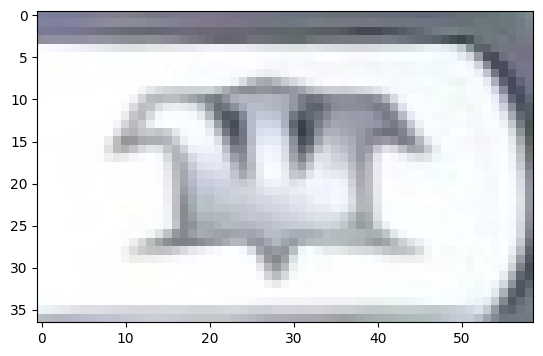

Found exact match: abattoir ghoul
https://svgs.scryfall.io/sets/isd.svg?1673845200
https://svgs.scryfall.io/sets/ddq.svg?1673845200
(37, 59, 3) <class 'numpy.ndarray'> uint8
(37, 59, 3) <class 'numpy.ndarray'> uint8
SET_URL: https://svgs.scryfall.io/sets/isd.svg?1673845200


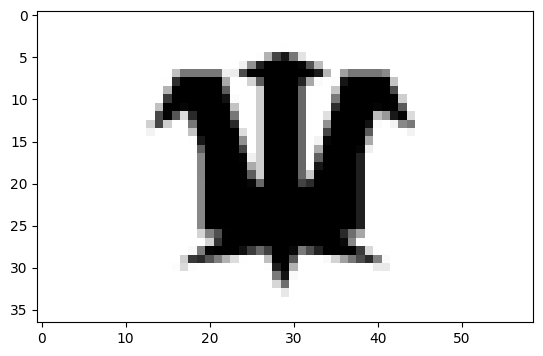

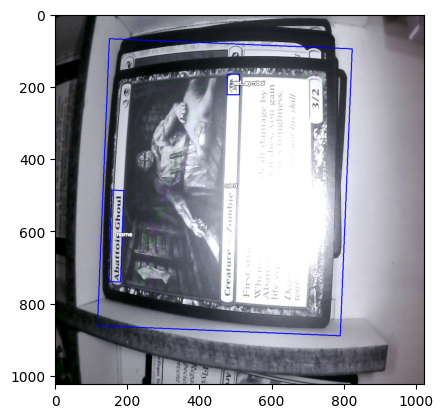

Running on D:\processed_pics\test\98a42ac8-Photo_on_1-19-23_at_11.48_PM_3_1024x1024.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
0.9391909457355799 (592, 466)
CardName:  [[('Infernal Pet', 0.9487491250038147)]]


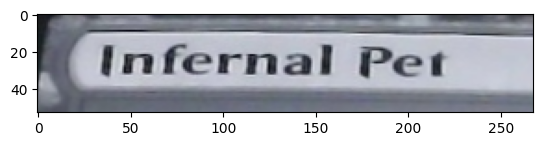

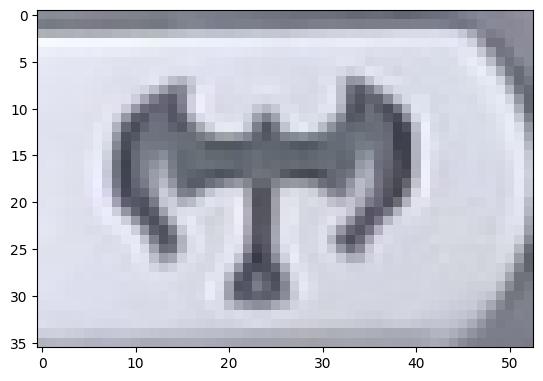

Found exact match: infernal pet
https://svgs.scryfall.io/sets/khm.svg?1673845200
(36, 53, 3) <class 'numpy.ndarray'> uint8
(36, 53, 3) <class 'numpy.ndarray'> uint8
SET_URL: https://svgs.scryfall.io/sets/khm.svg?1673845200


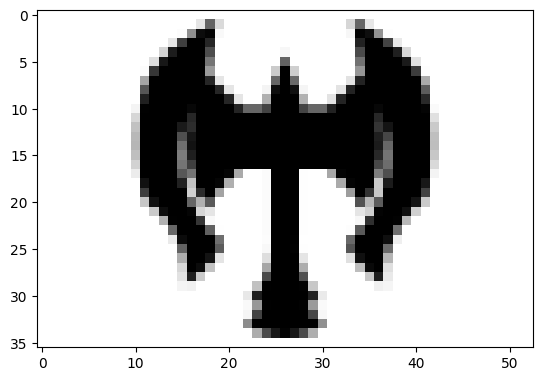

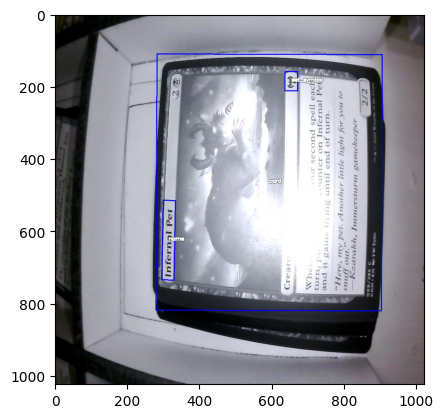

Running on D:\processed_pics\test\99b4c500-Photo_on_1-19-23_at_11.50_PM_2_1024x1024.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
1.3915266525478245 (539, 484)
CardName:  [[('Ornithopter', 0.9615113735198975)]]


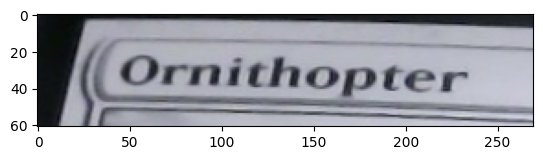

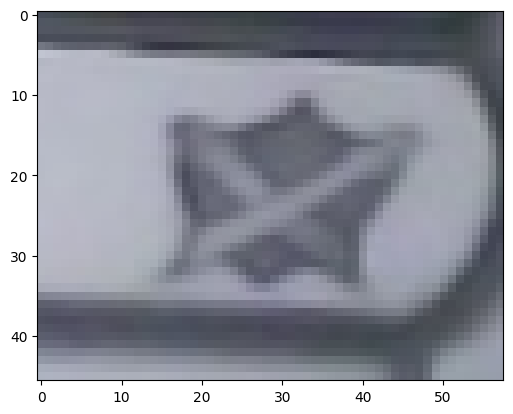

Found exact match: ornithopter
https://svgs.scryfall.io/sets/mrd.svg?1673845200
https://svgs.scryfall.io/sets/m11.svg?1673845200
https://svgs.scryfall.io/sets/psum.svg?1673845200
https://svgs.scryfall.io/sets/3ed.svg?1673845200
https://svgs.scryfall.io/sets/aer.svg?1673845200
https://svgs.scryfall.io/sets/m10.svg?1673845200
https://svgs.scryfall.io/sets/klr.svg?1673845200
https://svgs.scryfall.io/sets/6ed.svg?1673845200
https://svgs.scryfall.io/sets/planeswalker.svg?1673845200
https://svgs.scryfall.io/sets/psal.svg?1673845200
https://svgs.scryfall.io/sets/mps.svg?1673845200
https://svgs.scryfall.io/sets/default.svg?1673845200
https://svgs.scryfall.io/sets/5ed.svg?1673845200
https://svgs.scryfall.io/sets/dmr.svg?1673845200
https://svgs.scryfall.io/sets/star.svg?1673845200
https://svgs.scryfall.io/sets/9ed.svg?1673845200
https://svgs.scryfall.io/sets/m15.svg?1673845200
https://svgs.scryfall.io/sets/10e.svg?1673845200
https://svgs.scryfall.io/sets/brr.svg?1673845200
https://svgs.scryfall.

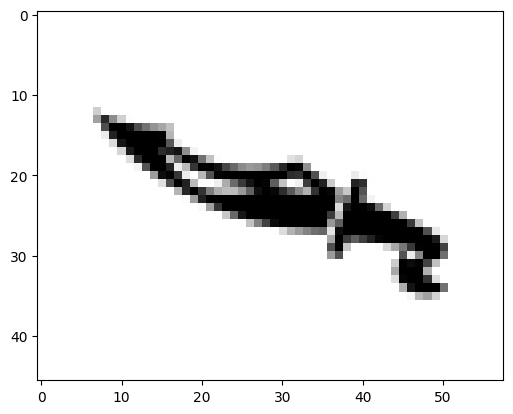

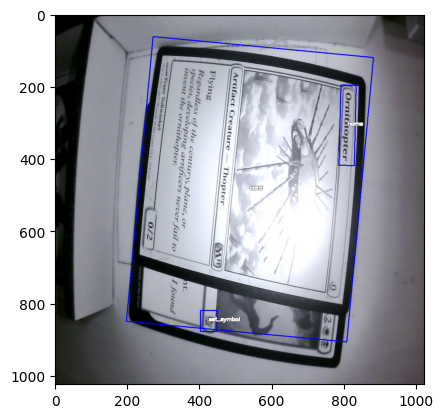

Running on D:\processed_pics\test\b04e2f4c-Photo_on_1-19-23_at_11.51_PM_3_1024x1024.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
9.912751446723837 (543, 444)
CardName:  [[('Trenacious Hunrer', 0.9387998580932617)]]


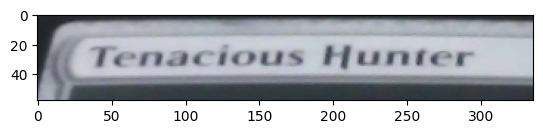

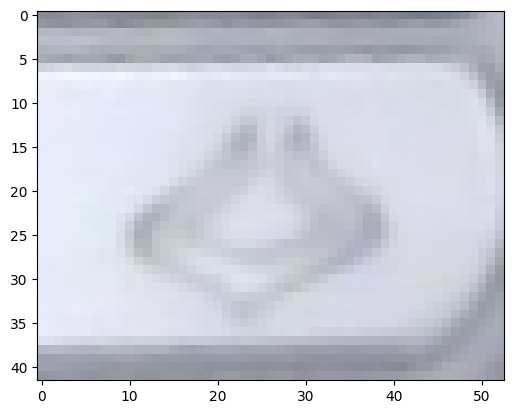

guessing with ratio of 0.13793103448275867: tenacious hunter
https://svgs.scryfall.io/sets/hou.svg?1673845200
(42, 53, 3) <class 'numpy.ndarray'> uint8
(42, 53, 3) <class 'numpy.ndarray'> uint8
SET_URL: https://svgs.scryfall.io/sets/hou.svg?1673845200


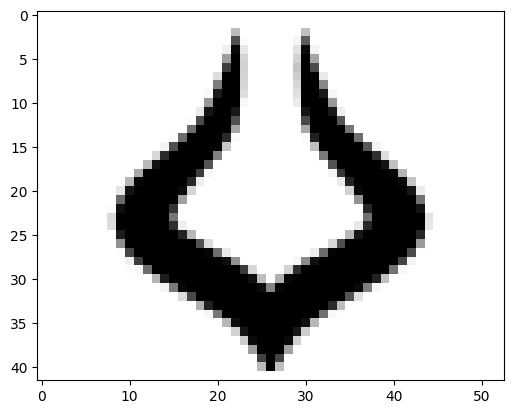

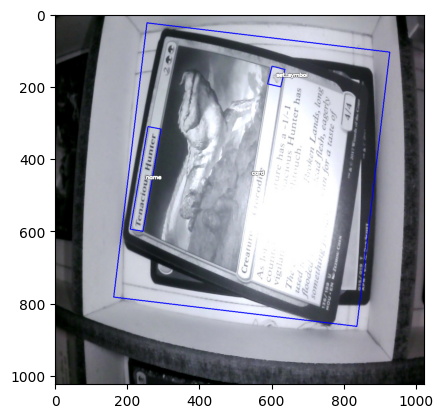

In [62]:
# files = [x for x in get_file_paths(r'C:\Users\kian\Downloads\Photos-001') if x.endswith('.jpg')]
# random.shuffle(files)
# fname = r"C:\Users\kian\Downloads\20230102_121318.jpg"
for i in range(len(files)):
    fname = files[i]
    detect_and_guess(model, fname)